# Scripts

In [1]:
%run '../shared-code/utils.py'

# Dependencies

In [2]:
import pandas as pd 
from sklearn.svm import SVR
import seaborn as sns 
import joblib
import sklearn
import copy 
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
import scipy

%matplotlib inline 

# Utils 

In [3]:
def plot_3d_cv_results(fine_tuner,xs,ys,x_name,y_name):
    splits_keys=[f'split{i}_test_score' for i in range(6)]
    cv_res=fine_tuner.cv_results_
    split_matrix=[]
    for split_key in splits_keys:
        split_matrix.append(cv_res[split_key])
    split_matrix=np.array(split_matrix)
    split_matrix=split_matrix.T
    cv_avrgs=[]
    for split in split_matrix:
        cv_avrgs.append(np.mean(split))

    x=[]
    y=[]

    for p in fine_tuner.cv_results_['params']: 
        x.append(p[x_name])
        y.append(p[y_name])

    x_grid = np.linspace(min(xs), max(xs), 100)
    y_grid = np.linspace(min(ys), max(ys), 100)
    x_ratio_grid, y_ratio_grid = np.meshgrid(x_grid, y_grid)

    Z = scipy.interpolate.griddata(
        (x, y),
        cv_avrgs,
        (x_ratio_grid, y_ratio_grid),
        method='linear'
    )

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x_ratio_grid, y_ratio_grid, Z, cmap='viridis')
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_zlabel('CV Score')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# Load & Process datasets  

In [4]:
tr=pd.read_csv('../data/train.csv',index_col=INDEX_COL)
tr.sample(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Index,,,,,,,,,,,,,,,,,,,,,
1038,1039,160,RM,21.0,1533,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,97000
942,943,90,RL,42.0,7711,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,Oth,Abnorml,150000


In [5]:
X_tr,y_tr=tr.drop(TARGET_COL,axis=1),tr[TARGET_COL]

In [6]:
data_pipe:sklearn.pipeline.Pipeline=joblib.load('../pipelines/data_pipeline.pkl')
data_pipe.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x74de2ce74700>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'RoofStyle', 'RoofMatl',
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x74de2b949cf0>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x74de2c421e10>))])

In [7]:
test=pd.read_csv('../data/test.csv')
X_test,y_test=test.drop(TARGET_COL,axis=1),test[TARGET_COL]

## Pretpostavki

- High dimensional kernels nemat da imat golemo vlijanie, zaradi golemata dimensionalnost na datasetot.  

# Scalling the data 

In [8]:
data_pipe_scalling=copy.deepcopy(data_pipe)
data_pipe_scalling.steps.append(("Scalling",MinMaxScaler()))
data_pipe_scalling.fit(X_tr)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function modify_features at 0x74de2ce74700>)),
                ('columntransformer-1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('simpleimputer-1',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant'),
                                                  ['Alley', 'MasVnrType',
                                                   'FireplaceQu', 'PoolQC',
                                                   'Fence', 'MiscFeature',
                                                   'GarageType', 'GarageFini...
                                                   'Exterior1st', 'Exterior2nd',
                                                   'Foundation', 'Heating',
                                                   'CentralAir', 'Electrical',
                                                   'GarageType', 'MiscFeature',
                                                   'SaleType', 'SaleCondition',
                                                   'MasVnrType'])])),
                ('functiontransformer-4',
                 FunctionTransformer(func=<__main__.PdWrapper object at 0x74de2b948e50>)),
                ('functiontransformer-5',
                 FunctionTransformer(func=<function conv_npfloat64 at 0x74de2c421e10>)),
                ('Scalling', MinMaxScaler())])

In [9]:
X_tr_scalled,X_test_scalled=data_pipe_scalling.transform(X_tr), \
    data_pipe_scalling.transform(X_test)

## Linear kernel 

Bidejki varijansata na vakvime modeli e dosta golema parametrite mora da gi odberime preku cross validation. 

In [10]:
C_VALS=np.logspace(start=1,stop=20,base=0.1)
C_VALS=np.concatenate([C_VALS,np.logspace(start=1,stop=5,base=10)])
ERR_COEF=np.linspace(0,1,num=10)

In [11]:
svm=SVR(kernel='linear',max_iter=int(10e4))
fine_tuner=GridSearchCV(
    estimator=svm,
    param_grid={
        "C":C_VALS,
        "epsilon":[e*y_tr.min() for e in ERR_COEF ]
    },
    cv=6,
    scoring=house_pricing_metric
)
fine_tuner.fit(X_tr_scalled,y_tr)

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/viktor/anaconda3/envs/ml/lib/python3.10/si

GridSearchCV(cv=6, estimator=SVR(kernel='linear', max_iter=100000),
             param_grid={'C': array([1.00000000e-01, 4.09491506e-02, 1.67683294e-02, 6.86648845e-03,
       2.81176870e-03, 1.15139540e-03, 4.71486636e-04, 1.93069773e-04,
       7.90604321e-05, 3.23745754e-05, 1.32571137e-05, 5.42867544e-06,
       2.22299648e-06, 9.10298178e-07, 3.72759372e-07, 1.52641797e-07,
       6.25055193e-08, 2.55954...
       2.68269580e+04, 3.23745754e+04, 3.90693994e+04, 4.71486636e+04,
       5.68986603e+04, 6.86648845e+04, 8.28642773e+04, 1.00000000e+05]),
                         'epsilon': [0.0, 3877.7777777777774, 7755.555555555555,
                                     11633.333333333332, 15511.11111111111,
                                     19388.88888888889, 23266.666666666664,
                                     27144.44444444444, 31022.22222222222,
                                     34900.0]},
             scoring=make_scorer(rmse_logs, response_method='predict'))

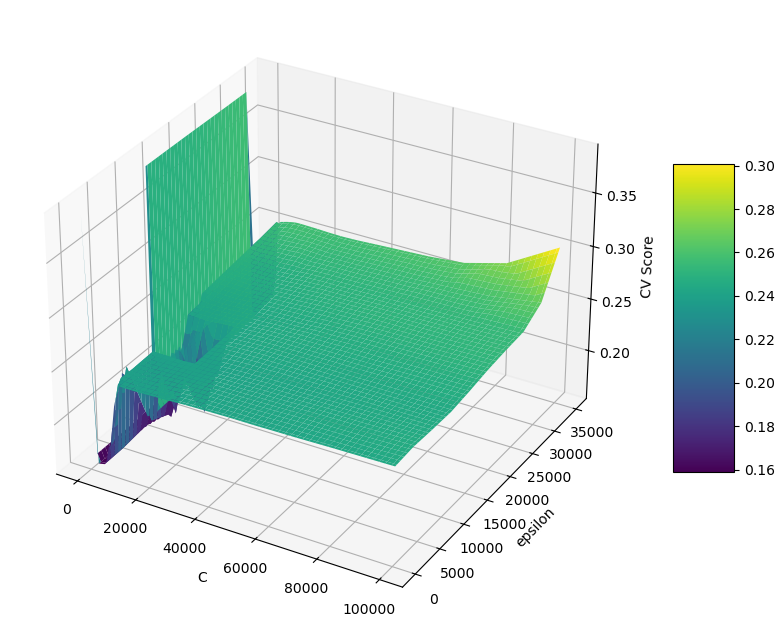

In [12]:
plot_3d_cv_results(fine_tuner=fine_tuner,xs=C_VALS,ys=[e*y_tr.min() for e in ERR_COEF],x_name='C',y_name='epsilon')

In [13]:
svm=SVR(kernel='linear',max_iter=int(10e4))
C_VALS=np.logspace(start=1,base=0.1,stop=20)
fine_tuner=GridSearchCV(
    estimator=svm,
    param_grid={
        "C":C_VALS,
        "epsilon":[e*y_tr.min() for e in ERR_COEF ]
    },
    cv=6,
    scoring=house_pricing_metric
)
fine_tuner.fit(X_tr_scalled,y_tr)

GridSearchCV(cv=6, estimator=SVR(kernel='linear', max_iter=100000),
             param_grid={'C': array([1.00000000e-01, 4.09491506e-02, 1.67683294e-02, 6.86648845e-03,
       2.81176870e-03, 1.15139540e-03, 4.71486636e-04, 1.93069773e-04,
       7.90604321e-05, 3.23745754e-05, 1.32571137e-05, 5.42867544e-06,
       2.22299648e-06, 9.10298178e-07, 3.72759372e-07, 1.52641797e-07,
       6.25055193e-08, 2.55954...
       3.08884360e-17, 1.26485522e-17, 5.17947468e-18, 2.12095089e-18,
       8.68511374e-19, 3.55648031e-19, 1.45634848e-19, 5.96362332e-20,
       2.44205309e-20, 1.00000000e-20]),
                         'epsilon': [0.0, 3877.7777777777774, 7755.555555555555,
                                     11633.333333333332, 15511.11111111111,
                                     19388.88888888889, 23266.666666666664,
                                     27144.44444444444, 31022.22222222222,
                                     34900.0]},
             scoring=make_scorer(rmse_logs, response_method='predict'))

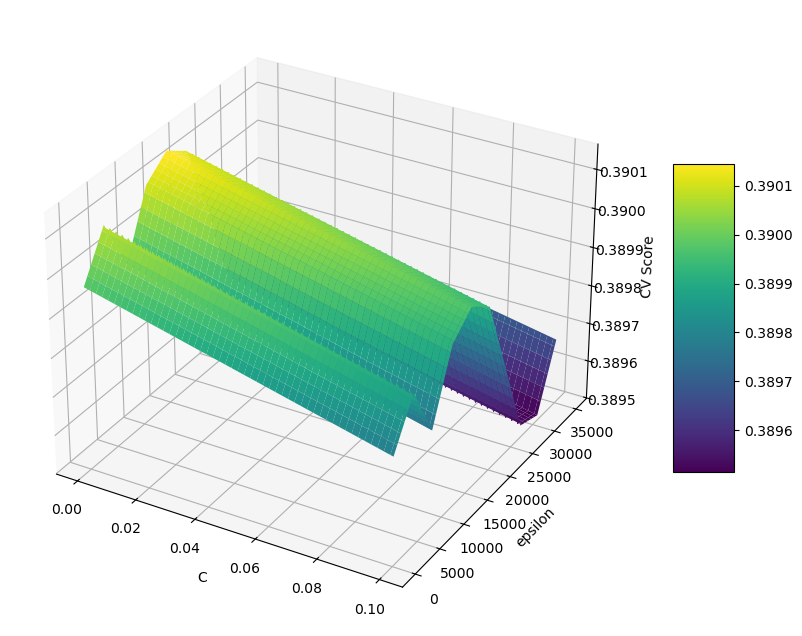

In [14]:
plot_3d_cv_results(fine_tuner=fine_tuner,xs=C_VALS,ys=[e*y_tr.min() for e in ERR_COEF],x_name='C',y_name='epsilon')

Zaradi conveksnota na SVM sigurni sme deka naidovme na globalen minimum.

In [15]:
fine_tuner.best_score_

0.39015044380633795

Znachit deka i najdobriot model ne e bash podobar od linearna regresija. 

In [16]:
fine_tuner.best_params_

{'C': 3.9069399370546236e-14, 'epsilon': 15511.11111111111}

In [17]:
best_svm=fine_tuner.best_estimator_
best_svm.fit(X_tr_scalled,y_tr)

SVR(C=3.9069399370546236e-14, epsilon=15511.11111111111, kernel='linear',
    max_iter=100000)

In [18]:
rmse_logs(y_test,best_svm.predict(X_test_scalled))

0.43217296623422646

Dosta losh score za test datasetot. 

Ochekuvano deka sepak najdobriot na validation setot vagashe 0.39 rmse_logs.

## Objasnuvanje na errorot

Errot e dosta chuden bidejki linear regression davashe podobri rezultati od ova. Edinstvenata razlika pomegu ovie 2 modeli e toa shto edniot go zemat najmaliot error pri fitvenje dodeka drugiot ostavat epsilon greshka pomegu features. 

Pretopostavuvam deka faktot deka SVR barat generalen epsilon za site samples, dodeka pak LinearRegression izbirat epsilon za sekoj sample posebno (odnosno barat kombinacija na epsilons t.s. celosniot error bi se namalil), ke e voditel vo toa shto SVR(kernel='line') ne gi postignuva istite rezultati.

Vaka ke napreme za da ja proverime pretpostavkata. Najprvin da ja vizuelizirame granicata na predictions na koi mu asocirame 0 penalty.

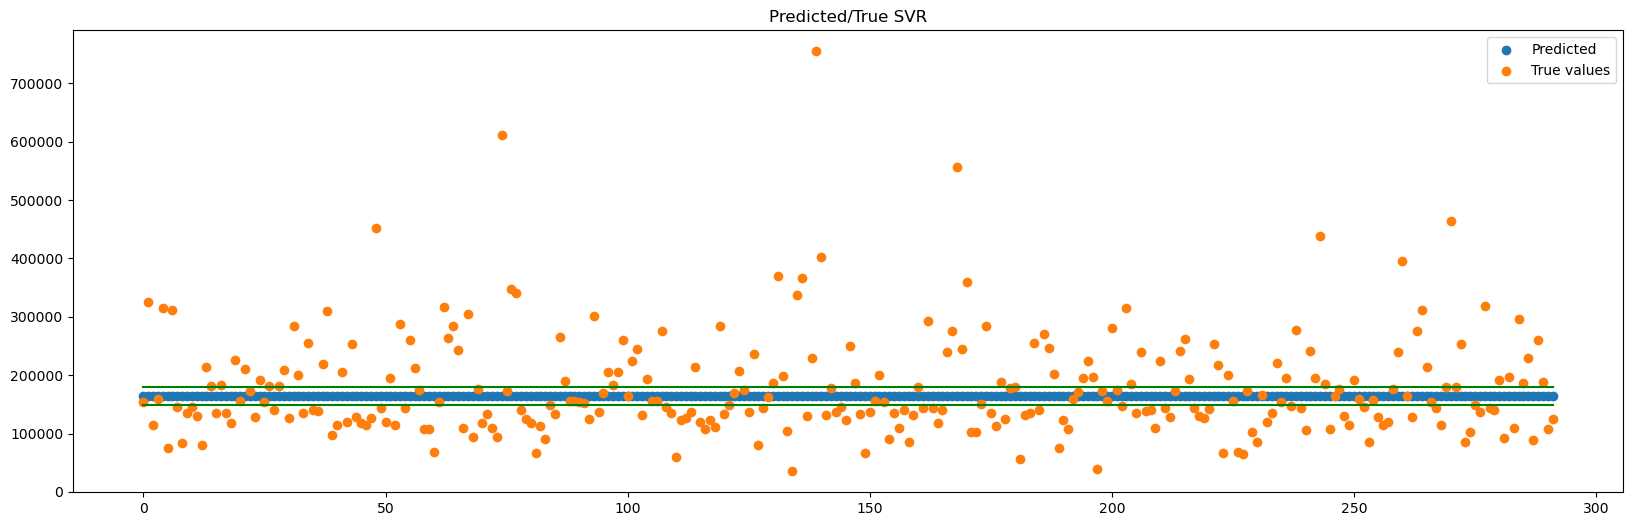

In [19]:
y_pred=best_svm.predict(X_test_scalled)
best_epsilon=fine_tuner.best_params_['epsilon']

plt.figure(figsize=(20,6))

plt.title("Predicted/True SVR")

plt.scatter(x=X_test.index.values,y=y_pred,label='Predicted')
plt.scatter(x=X_test.index.values,y=y_test,label='True values')

plt.legend()

plt.plot(X_test.index.values,[y+best_epsilon for y in y_pred],label='Decision+Epsilon',c='g')
plt.plot(X_test.index.values,[y-best_epsilon for y in y_pred],label='Decision-Epsilon',c='g')

plt.show() 

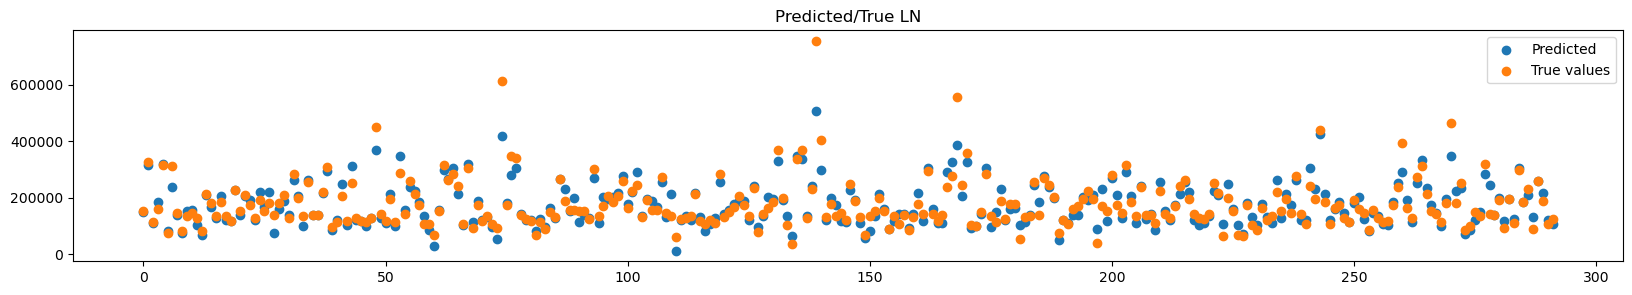

In [20]:
ln=sklearn.linear_model.LinearRegression()
ln.fit(X_tr_scalled,y_tr)

y_pred=ln.predict(X_test_scalled)

plt.figure(figsize=(20,3))

plt.title("Predicted/True LN")

plt.scatter(x=X_test.index.values,y=y_pred,label='Predicted')
plt.scatter(x=X_test.index.values,y=y_test,label='True values')

plt.legend()
plt.show() 

Imat smisla ova deka sepak e high dimensonal space pa posle ko ke gi mapirame vo lower dimensional space stanvat nelinearni.

Da probame so epsilon=0 

In [21]:
lin_svm=SVR(kernel='linear',epsilon=0,C=1e6,max_iter=int(10e6))
lin_svm.fit(X_tr_scalled,y_tr)
rmse_logs(y_test,lin_svm.predict(X_test_scalled))

/home/viktor/anaconda3/envs/ml/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.18128487116270658

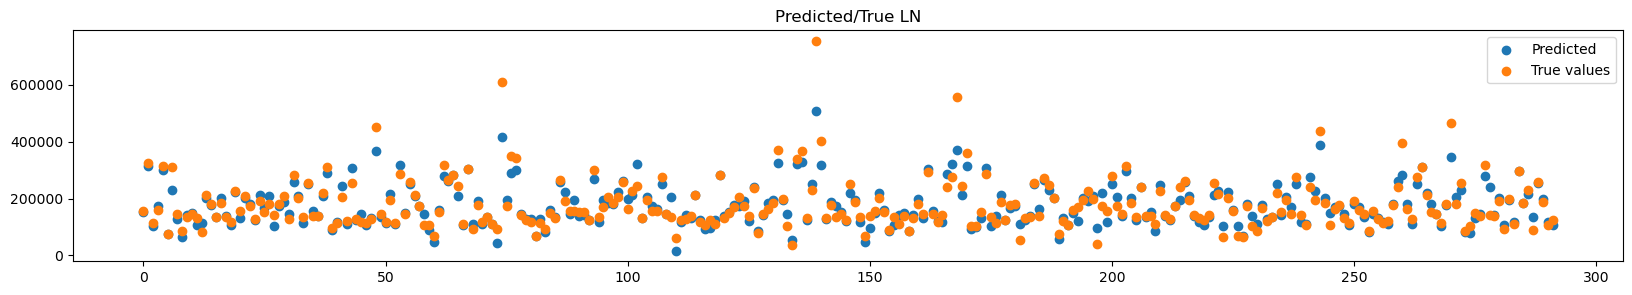

In [22]:
y_pred=lin_svm.predict(X_test_scalled)

plt.figure(figsize=(20,3))
plt.title("Predicted/True LN")

plt.scatter(x=X_test.index.values,y=y_pred,label='Predicted')
plt.scatter(x=X_test.index.values,y=y_test,label='True values')

plt.legend()
plt.show() 

Ako ne e to togash premnogu imat varijansa, bidejki ochigledno za train datasetot, kako celina, najdobra vrednost e epsilon=0, a vo cross validationot se obiduva da ja najt ta kombinacija sho go namalvit averageot na greshkata. 

In [110]:
tmp=sorted(fine_tuner.cv_results_['std_test_score'])
tmp[0],tmp[-1]

(0.02773802927682831, 0.028479285141293303)

Spored ova varijansata pomegu splits ne e tolku golema. Sho znachit deka ne e premnogu varijablien modelot. Znachit ne e to.

Ostanvit da vidime dali tie 20% od podatocite sho gi trgame vo validation datasetot mnogu smetaat na slikata sho ja dobivat modelot za datatsetot. 

In [25]:
list(fine_tuner.cv_results_.keys())

['mean_fit_time',
 'std_fit_time',
 'mean_score_time',
 'std_score_time',
 'param_C',
 'param_epsilon',
 'params',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'split5_test_score',
 'mean_test_score',
 'std_test_score',
 'rank_test_score']

Kako da proverime dali samata funkcija e nelinearna.  

## Polynomial kernel 

## RBF kernel 